# Black Hole Mass Predictor

## Import Libraries

In [38]:
from astropy.io import fits
from astropy.table import Table
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ast
import os

## Read Data

In [2]:
fits_file = fits.open("data/DR16.fits")
fits_file_small = fits.open("data/DR16_Z.fits")

print(fits_file)

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000001FCBA145AC0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000001FCD8DF2390>]


In [3]:
DR16_fits = Table.read("data/DR16.fits")

print(DR16_fits)

   SDSS_NAME_1              RA_1         ...       Separation      
                                         ...         arcsec        
------------------ --------------------- ... ----------------------
000000.15+353104.2 0.0006294989251500738 ... 2.1615165486634594e-13
000000.33+310325.3 0.0014145086271355467 ...  1.442806039065566e-13
000000.36+070350.8 0.0015353689425410266 ...   9.50160001818925e-14
000000.36+274356.2 0.0015264841092630377 ...  1.200037972740516e-13
000000.45+092308.2 0.0019139323820809295 ... 1.0480352304269532e-13
000000.45+174625.4 0.0018982743563356053 ... 1.8633879837315987e-14
000000.47-002703.9  0.001978307141598634 ... 1.2299420115256465e-13
000000.57+055630.8 0.0023754761888312714 ...  2.557959443600196e-13
000000.62+311944.3 0.0025954542353474608 ...  1.874444456223307e-13
               ...                   ... ...                    ...
235959.64-044037.6    359.99853776089265 ...                    0.0
235959.70+084505.2     359.9987743613988 ...    

### Moving data from DR16_Z.fits to DR16_Z.csv

    import pandas as pd
    
    fits_file = 'DR16_Z.fits'
    
    csv_file = 'DR16_Zcsv.csv'
    
    
    with fits.open(fits_file) as hdul:
    
        hdul.info()
    
        data_hdu = hdul[1].data 
    
        df = pd.DataFrame(data_hdu)
    
        df.to_csv(csv_file, index=False)
    
    print(f"Data has been converted to a CSV File: {csv_file}")

### Renamed the DR16_Z.csv file DR16_small

In [4]:
file_bath = "data/DR16_Z.csv"

DR16_small = pd.read_csv(file_bath)

print(DR16_small.head())

          SDSS_NAME_1      RA_1      DEC_1         Z  GALEX_MATCHED       FUV  \
0  000000.33+310325.3  0.001415  31.057048  2.035491              1  0.279323   
1  000000.45+092308.2  0.001914   9.385637  2.024146              1  4.856251   
2  000000.45+174625.4  0.001898  17.773739  2.309000              1  0.302319   
3  000000.57+055630.8  0.002375   5.941903  2.102771              1  0.000000   
4  000000.66+145828.8  0.002756  14.974675  2.497000              1  0.046319   

        NUV  FIRST_MATCHED  FIRST_FLUX  XMM_SOFT_FLUX  ...  GAIA_G_MAG  \
0  0.165177              0        -1.0           -1.0  ...   -1.000000   
1  8.220212              0        -1.0           -1.0  ...   18.343128   
2  0.727565              0        -1.0           -1.0  ...   -1.000000   
3  0.000000              0        -1.0           -1.0  ...   -1.000000   
4  0.052530              0        -1.0           -1.0  ...   20.838264   

   GAIA_G_FLUX_SNR   Z_DR16Q     Z_FIT    LOGLBOL  LOGLBOL_ERR    LO

In [5]:
print(len(DR16_small.columns))

30


### Moving data from DR16.fits to DR16.csv

We need to decompose some columns in DR16 from 2D to 2D and 1D 

    from astropy.io import fits
    import pandas as pd
    
    fits_file = 'DR16.fits'
    
    csv_file = 'DR16csv.csv'
    
    
    with fits.open(fits_file) as hdul:
    
        hdul.info()
        
        data_hdu = hdul[1].data
        
        df = pd.DataFrame({col.name: data_hdu[col.name].tolist() 
                           if data_hdu[col.name].ndim > 1 else data_hdu[col.name]
                           for col in data_hdu.columns})
                           
        df.to_csv(csv_file, index=False)
    
    print(f"تم تحويل البيانات إلى ملف CSV: {csv_file}")

### Renamed the DR16csv.csv file to DR16_full

In [4]:
file_bath = r"C:\Users\basil\PycharmProjects\DR16_Reference\DR16_csv.csv"

DR16_data = pd.read_csv(file_bath)

print(DR16_data.head())

          SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
0  000000.15+353104.2  0.000629  35.517841     7750  58402        802   
1  000000.33+310325.3  0.001415  31.057048     7749  58073        660   
2  000000.36+070350.8  0.001535   7.064129    11279  58449        978   
3  000000.36+274356.2  0.001526  27.732283     7695  57654        565   
4  000000.45+092308.2  0.001914   9.385637    11277  58450        705   

  AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...  LOGMBH_MGII_ERR  \
0           QSO             QSO          1  0.844138  ...         0.036066   
1           QSO             QSO          1  2.026023  ...        -1.000000   
2           QSO             QSO          1  1.565547  ...         0.355488   
3           QSO             QSO          1  1.774408  ...         0.115791   
4           QSO             QSO          1  2.033733  ...        -1.000000   

   LOGMBH_CIV  LOGMBH_CIV_ERR    LOGMBH  LOGMBH_ERR  LOGLEDD_RATIO  \
0    0.000000       -1

In [5]:
print("Numer of columns:",len(DR16_data.columns))

Numer of columns: 298


In [6]:
print("Numer of rows:",len(DR16_data))

Numer of rows: 750414


## Data Cleaning

### We will split each of the `HALPHA`, `HBETA`, `MGII`, `CIV` columns into six separate values since each column represents six different measurements:
    Peak Wavelength (Angstroms, Å)
    Example value: 1546.1966286184108
    
    50% Flux Centroid Wavelength (Angstroms, Å)
    Example value: 1546.3116696262705
    
    Flux (10^−17 erg s−1 cm−2)
    Example value: 70.71865738663368
    
    Logarithm of Line Luminosity (logLline) (erg s−1)
    Example value: 43.329111154876585
    
    FWHM (Full Width at Half Maximum in km s−1)
    Example value: 7300.695492499235
    
    Rest-frame Equivalent Width (REW) (Angstroms, Å)
    Example value: 24.44456687554046

In [7]:
def convert_to_list(value):
    try:
        return ast.literal_eval(value)  
    except (ValueError, SyntaxError):
        return None

columns_to_split = ['HBETA', 'HALPHA', 'MGII', 'CIV']
for col in columns_to_split:
    DR16_data[col] = DR16_data[col].apply(convert_to_list)

In [8]:
print(DR16_data['HBETA'].apply(type).value_counts())
print(DR16_data['HBETA'].head())

HBETA
<class 'list'>    750414
Name: count, dtype: int64
0    [4862.538395321536, 4854.166496184568, 1555.60...
1                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: HBETA, dtype: object


In [9]:

for col in columns_to_split:
    DR16_data[f'{col}_Peak_Wavelength'] = DR16_data[col].apply(
        lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None
    )
    DR16_data[f'{col}_50%_Flux_Centroid_Wavelength'] = DR16_data[col].apply(
        lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None
    )
    DR16_data[f'{col}_Flux'] = DR16_data[col].apply(
        lambda x: x[2] if isinstance(x, list) and len(x) > 2 else None
    )
    DR16_data[f'{col}_Logarithm_of_Line_Luminosity'] = DR16_data[col].apply(
        lambda x: x[3] if isinstance(x, list) and len(x) > 3 else None
    )
    DR16_data[f'{col}_FWHM'] = DR16_data[col].apply(
        lambda x: x[4] if isinstance(x, list) and len(x) > 4 else None
    )
    DR16_data[f'{col}_REW'] = DR16_data[col].apply(
        lambda x: x[5] if isinstance(x, list) and len(x) > 5 else None
    )


In [10]:
DR16_data['MGII_FWHM'].head()

0    4819.454174
1    4375.115431
2    2081.773906
3    6126.957875
4    4989.288165
Name: MGII_FWHM, dtype: float64

In [11]:
DR16_data.drop(columns=columns_to_split, inplace=True)

### Cleaning the `LOGMBH` (target feature)

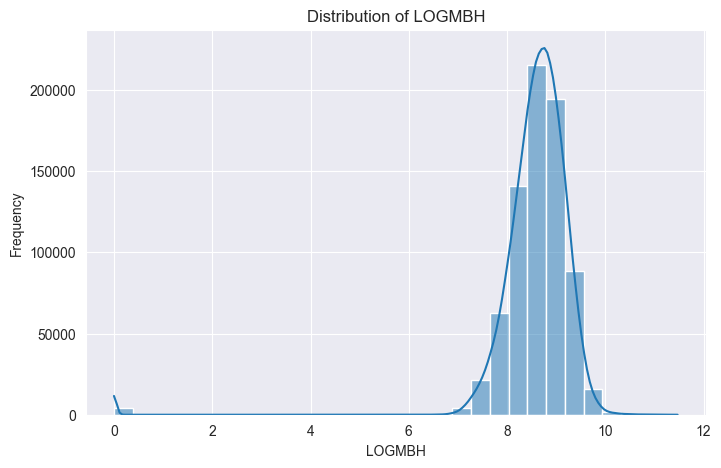

In [12]:
columns_to_plot = ["LOGMBH"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [14]:
# Assuming DR16_full['LOGMBH'] is your column
# Define bins from 0 to 10 with step 0.25
bins = [i * 0.25 for i in range(41)]  # Bins: 0, 0.25, ..., 10.0

# Bin the data and count occurrences
binned_counts = pd.cut(
    DR16_data["LOGMBH"], bins=bins, include_lowest=True).value_counts().sort_index()

# Print the counts for each bin
print(binned_counts)

LOGMBH
(-0.001, 0.25]      4142
(0.25, 0.5]            0
(0.5, 0.75]            0
(0.75, 1.0]            0
(1.0, 1.25]            0
(1.25, 1.5]            0
(1.5, 1.75]            0
(1.75, 2.0]            0
(2.0, 2.25]            0
(2.25, 2.5]            0
(2.5, 2.75]            0
(2.75, 3.0]            0
(3.0, 3.25]            0
(3.25, 3.5]            1
(3.5, 3.75]            1
(3.75, 4.0]            0
(4.0, 4.25]            3
(4.25, 4.5]            2
(4.5, 4.75]            2
(4.75, 5.0]            4
(5.0, 5.25]            9
(5.25, 5.5]            5
(5.5, 5.75]            9
(5.75, 6.0]           15
(6.0, 6.25]            7
(6.25, 6.5]           31
(6.5, 6.75]          102
(6.75, 7.0]          646
(7.0, 7.25]         3535
(7.25, 7.5]        10404
(7.5, 7.75]        22454
(7.75, 8.0]        44106
(8.0, 8.25]        77658
(8.25, 8.5]       116027
(8.5, 8.75]       143819
(8.75, 9.0]       141225
(9.0, 9.25]       105662
(9.25, 9.5]        55658
(9.5, 9.75]        18957
(9.75, 10.0]      

In [15]:
DR16_train_data = DR16_data[DR16_data['LOGMBH'] > 3.5].copy()

print("Original Data Shape:", DR16_data.shape)
print("Train Data Shape (LOGMBH > 3.5):", DR16_train_data.shape)

print("First 5 rows of DR16_data (unchanged):")
print(DR16_data.head())

print("\nFirst 5 rows of DR16_train_data (filtered):")
print(DR16_train_data.head())


Original Data Shape: (750414, 318)
Train Data Shape (LOGMBH > 3.5): (746271, 318)
First 5 rows of DR16_data (unchanged):
          SDSS_NAME_1      RA_1      DEC_1  PLATE_1  MJD_1  FIBERID_1  \
0  000000.15+353104.2  0.000629  35.517841     7750  58402        802   
1  000000.33+310325.3  0.001415  31.057048     7749  58073        660   
2  000000.36+070350.8  0.001535   7.064129    11279  58449        978   
3  000000.36+274356.2  0.001526  27.732283     7695  57654        565   
4  000000.45+092308.2  0.001914   9.385637    11277  58450        705   

  AUTOCLASS_PQN AUTOCLASS_DR14Q  IS_QSO_QN      Z_QN  ...    MGII_Flux  \
0           QSO             QSO          1  0.844138  ...  1111.403969   
1           QSO             QSO          1  2.026023  ...    89.734546   
2           QSO             QSO          1  1.565547  ...    28.815091   
3           QSO             QSO          1  1.774408  ...    87.786046   
4           QSO             QSO          1  2.033733  ...   576.581130

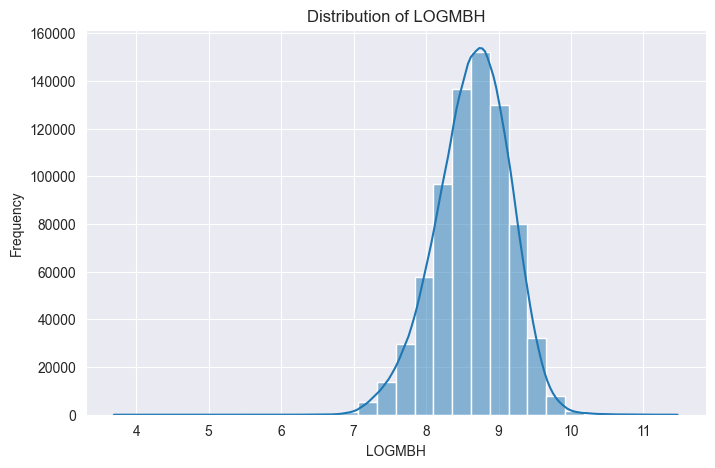

In [16]:
columns_to_plot = ['LOGMBH']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_train_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

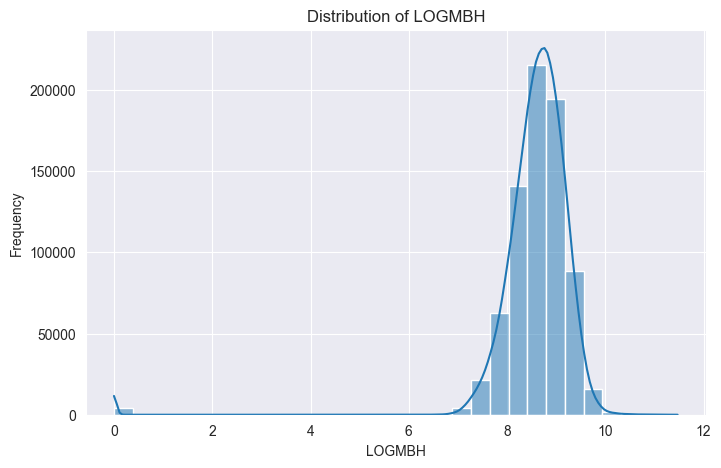

In [17]:
columns_to_plot = ['LOGMBH']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

### Cleaning the `Z_DR16Q`

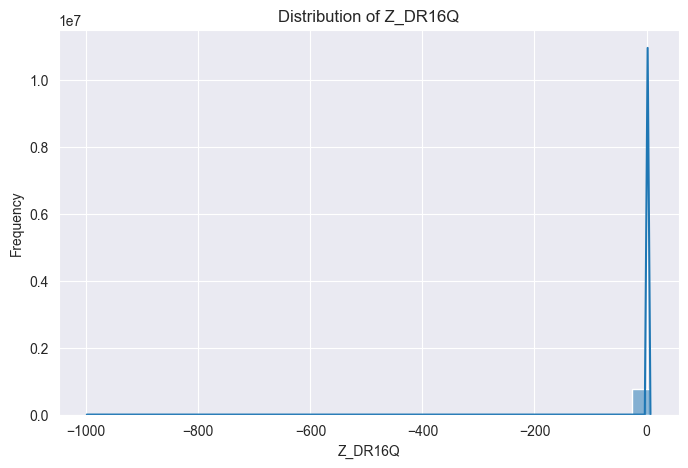

In [18]:
columns_to_plot = ['Z_DR16Q']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [19]:
bins = [i * 0.25 for i in range(41)]

binned_counts = pd.cut(
    DR16_data['Z_DR16Q'], bins=bins, include_lowest=True
).value_counts().sort_index()

print(binned_counts)

Z_DR16Q
(-0.001, 0.25]     2707
(0.25, 0.5]       16805
(0.5, 0.75]       44367
(0.75, 1.0]       68982
(1.0, 1.25]       79667
(1.25, 1.5]       90750
(1.5, 1.75]       93384
(1.75, 2.0]       84079
(2.0, 2.25]       78628
(2.25, 2.5]       76996
(2.5, 2.75]       46850
(2.75, 3.0]       27638
(3.0, 3.25]       19984
(3.25, 3.5]        9149
(3.5, 3.75]        4478
(3.75, 4.0]        2938
(4.0, 4.25]        1190
(4.25, 4.5]         568
(4.5, 4.75]         349
(4.75, 5.0]         240
(5.0, 5.25]         142
(5.25, 5.5]          75
(5.5, 5.75]          97
(5.75, 6.0]          77
(6.0, 6.25]          47
(6.25, 6.5]          57
(6.5, 6.75]          71
(6.75, 7.0]          51
(7.0, 7.25]          38
(7.25, 7.5]           0
(7.5, 7.75]           0
(7.75, 8.0]           0
(8.0, 8.25]           0
(8.25, 8.5]           0
(8.5, 8.75]           0
(8.75, 9.0]           0
(9.0, 9.25]           0
(9.25, 9.5]           0
(9.5, 9.75]           0
(9.75, 10.0]          0
Name: count, dtype: int64


Take all data Z_DR16Q = (0.5, 3.0)

In [20]:
DR16_data = DR16_data[DR16_data['Z_DR16Q'] > 0].copy()

DR16_train_data = DR16_train_data[DR16_train_data['Z_DR16Q'] > 0].copy()

print("Updated DR16_data shape:", DR16_data.shape)
print("Updated DR16_train_data shape:", DR16_train_data.shape)

DR16_data.to_csv("DR16_data_filtered.csv", index=False)
DR16_train_data.to_csv("DR16_train_data_filtered.csv", index=False)

Updated DR16_data shape: (750404, 318)
Updated DR16_train_data shape: (746266, 318)


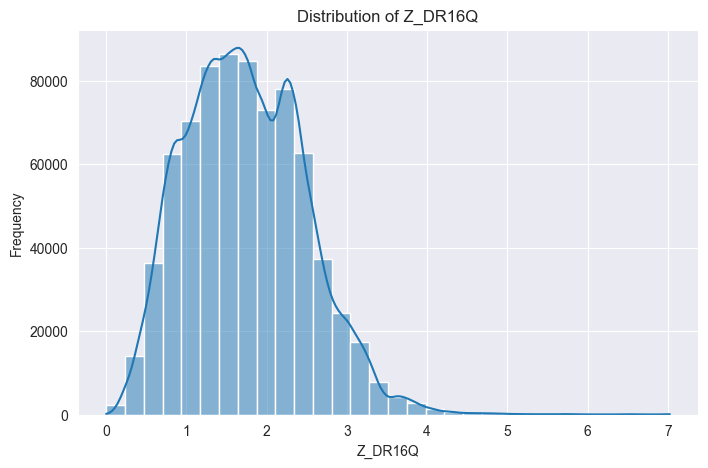

In [21]:
columns_to_plot = ['Z_DR16Q']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


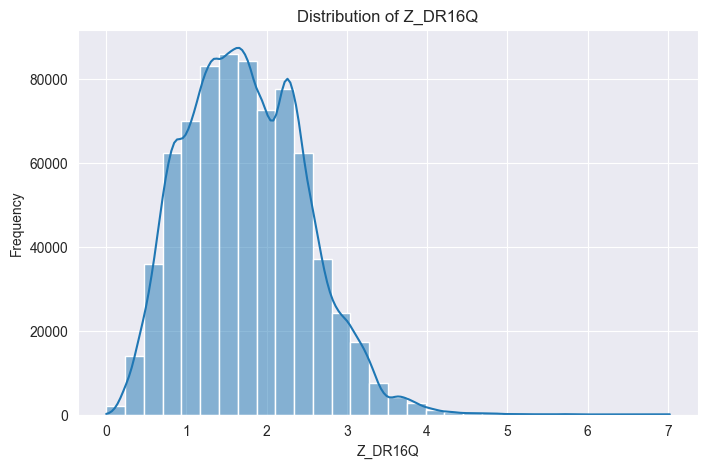

In [22]:
columns_to_plot = ['Z_DR16Q']
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_train_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


### Cleaning the `LOGMBH_ERR`

In [29]:
DR16_data1 = DR16_data
DR16_train_data1 = DR16_train_data

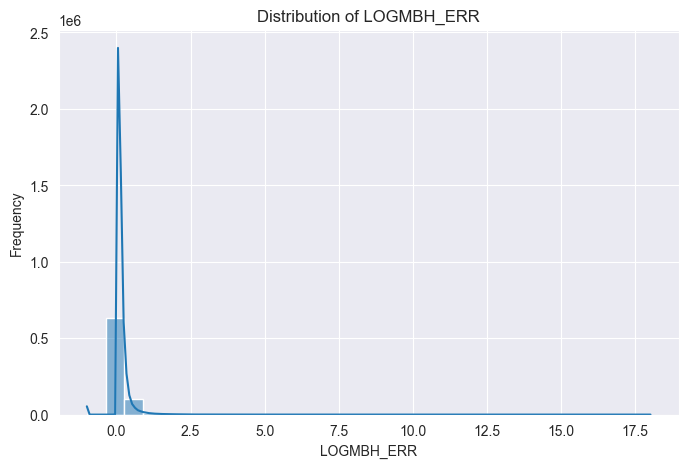

In [27]:
columns_to_plot = ["LOGMBH_ERR"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [28]:
bins = [i * 0.1 for i in range(101)]

binned_counts = pd.cut(DR16_data["LOGMBH_ERR"], bins=bins, include_lowest=True).value_counts().sort_index()

print(binned_counts)

LOGMBH_ERR
(-0.001, 0.1]    313671
(0.1, 0.2]       247640
(0.2, 0.3]        91370
(0.3, 0.4]        39159
(0.4, 0.5]        18067
                  ...  
(9.5, 9.6]            3
(9.6, 9.7]            0
(9.7, 9.8]            1
(9.8, 9.9]            0
(9.9, 10.0]           1
Name: count, Length: 100, dtype: int64


In [30]:
DR16_data = DR16_data[DR16_data["LOGMBH_ERR"] > -0.001 ].copy()

DR16_train_data = DR16_train_data[DR16_train_data["LOGMBH_ERR"] <= 0.3 ].copy()

print("Updated DR16_data shape:", DR16_data.shape)
print("Updated DR16_train_data shape:", DR16_train_data.shape)

DR16_data.to_csv("DR16_data_filtered.csv", index=False)
DR16_train_data.to_csv("DR16_train_data_filtered.csv", index=False)

Updated DR16_data shape: (746267, 318)
Updated DR16_train_data shape: (652681, 318)


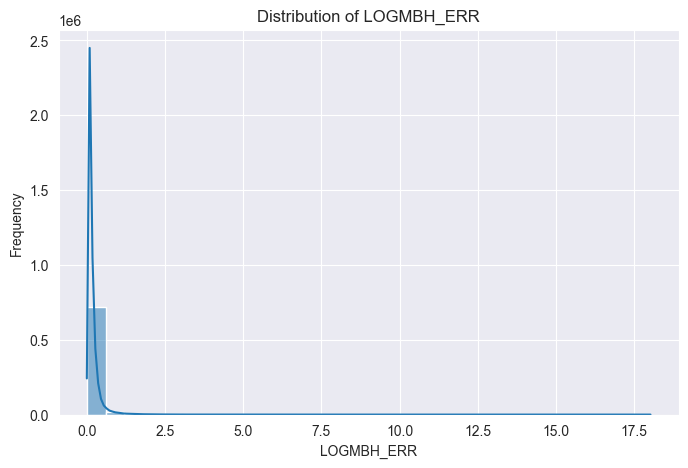

In [31]:
columns_to_plot = ["LOGMBH_ERR"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

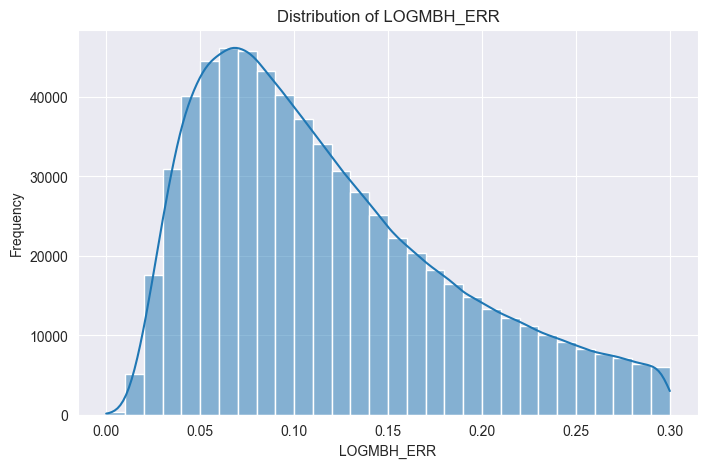

In [32]:
columns_to_plot = ["LOGMBH_ERR"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_train_data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [33]:
print(len(DR16_data))
print(len(DR16_train_data))

746267
652681


## Columns and Rows

### Columns

In [35]:
DR16_data1 = DR16_data
DR16_train_data1 = DR16_train_data

In [34]:
for column in DR16_data.columns:
    print(column)

SDSS_NAME_1
RA_1
DEC_1
PLATE_1
MJD_1
FIBERID_1
AUTOCLASS_PQN
AUTOCLASS_DR14Q
IS_QSO_QN
Z_QN
RANDOM_SELECT
Z_10K
Z_CONF_10K
PIPE_CORR_10K
IS_QSO_10K
THING_ID
Z_VI
Z_CONF
CLASS_PERSON
Z_DR12Q
IS_QSO_DR12Q
Z_DR7Q_SCH
IS_QSO_DR7Q
Z_DR6Q_HW
Z_DR7Q_HW
IS_QSO_FINAL
Z
SOURCE_Z
Z_PIPE
ZWARNING
OBJID_1
Z_PCA
ZWARN_PCA
DELTACHI2_PCA
Z_HALPHA
ZWARN_HALPHA
DELTACHI2_HALPHA
Z_HBETA
ZWARN_HBETA
DELTACHI2_HBETA
Z_MGII
ZWARN_MGII
DELTACHI2_MGII
Z_CIII
ZWARN_CIII
DELTACHI2_CIII
Z_CIV
ZWARN_CIV
DELTACHI2_CIV
Z_LYA
ZWARN_LYA
DELTACHI2_LYA
Z_LYAWG
Z_DLA
NHI_DLA
CONF_DLA
BAL_PROB
BI_CIV
ERR_BI_CIV
AI_CIV
ERR_AI_CIV
BI_SIIV
ERR_BI_SIIV
AI_SIIV
ERR_AI_SIIV
BOSS_TARGET1
EBOSS_TARGET0
EBOSS_TARGET1
EBOSS_TARGET2
ANCILLARY_TARGET1
ANCILLARY_TARGET2
NSPEC_SDSS
NSPEC_BOSS
NSPEC
PLATE_DUPLICATE
MJD_DUPLICATE
FIBERID_DUPLICATE
SPECTRO_DUPLICATE
SKYVERSION
RUN_NUMBER
RERUN_NUMBER
CAMCOL_NUMBER
FIELD_NUMBER
ID_NUMBER
LAMBDA_EFF
ZOFFSET
XFOCAL
YFOCAL
CHUNK
TILE
PLATESN2
PSFFLUX
PSFFLUX_IVAR
PSFMAG
PSFMAGERR
EXTINCTION


1) Z_DR16Q:

    الانزياح الأحمر (Redshift) المقدم من DR16Q.
    
    يمثل مقدار تمدد الضوء أثناء انتقاله من الجرم السماوي إلينا، وهو مؤشر للمسافة الكونية.
   

2) LOGMBH_HB, LOGMBH_MGII, LOGMBH_CIV: LOGLBOL

    كتلة الثقب الأسود (Black Hole Mass) محسوبة باستخدام خطوط Hβ، Mg II، و C IV.
    
    هذه الأعمدة تمثل حسابات الكتلة بناءً على خطوط الانبعاث المختلفة.


4) LOGMBH:

    الكتلة المرجعية أو النهائية للثقب الأسود (Fiducial Black Hole Mass).
    
    غالبًا ما تُعتبر المتوسط أو التقدير الأفضل.


5) LOGL5100, LOGL3000, LOGL1350:

    اللمعان (Luminosity) عند أطوال موجية معينة: 5100 Å، 3000 Å، و 1350 Å.
    
    تُستخدم هذه القيم لتقدير نشاط الجرم السماوي.


6) HBETA, MGII, CIV:

    خطوط انبعاث الطيف مثل Hβ، Mg II، و C IV.
    
    تُستخدم هذه الأعمدة لتحليل حركة الغاز وخصائص الثقب الأسود. (تحتوي على قوائم بيانات متعددة).


7) LOGMBH_HB_ERR, LOGMBH_MGII_ERR, LOGMBH_CIV_ERR, LOGMBH_ERR: LOGLOBOL_ERR

    الأخطاء المرتبطة بتقدير الكتلة باستخدام كل خط انبعاث أو كتلة الثقب المرجعية.
    
    تُظهر مدى دقة القياسات.


8) GAIA_G_FLUX_SNR, GAIA_BP_FLUX_SNR:

        نسبة الإشارة إلى الضوضاء (Signal-to-Noise Ratio) لمقاييس مختلفة.
        
        تُظهر جودة البيانات الطيفية لكل نطاق.
        8) GAIA_G_FLUX_SNR, GAIA_BP_FLUX_SNR,
            8) الاحمر الى الاخضرو ما بعد ذلك \


    

In [36]:
selected_columns = ["Z_DR16Q","LOGMBH_HB", "LOGMBH_MGII", "LOGMBH_CIV", "LOGMBH","LOGL5100", "LOGL3000", "LOGL1350","HBETA_Peak_Wavelength","HBETA_50%_Flux_Centroid_Wavelength", "HBETA_Flux", "HBETA_Logarithm_of_Line_Luminosity", "HBETA_FWHM", "HBETA_REW", "MGII_Peak_Wavelength", "MGII_50%_Flux_Centroid_Wavelength", "MGII_Flux", "MGII_Logarithm_of_Line_Luminosity", "MGII_FWHM", "MGII_REW", "CIV_Peak_Wavelength", "CIV_50%_Flux_Centroid_Wavelength", "CIV_Flux", "CIV_Logarithm_of_Line_Luminosity", "CIV_FWHM", "CIV_REW", "LOGMBH_HB_ERR", "LOGMBH_MGII_ERR", "LOGMBH_CIV_ERR", "LOGMBH_ERR","GAIA_G_FLUX_SNR", "GAIA_BP_FLUX_SNR"]

DR16_data_columns = DR16_data[selected_columns]
DR16_train_data_columns = DR16_train_data[selected_columns]

print(DR16_data_columns.columns)
print(DR16_train_data_columns.columns)

Index(['Z_DR16Q', 'LOGMBH_HB', 'LOGMBH_MGII', 'LOGMBH_CIV', 'LOGMBH',
       'LOGL5100', 'LOGL3000', 'LOGL1350', 'HBETA_Peak_Wavelength',
       'HBETA_50%_Flux_Centroid_Wavelength', 'HBETA_Flux',
       'HBETA_Logarithm_of_Line_Luminosity', 'HBETA_FWHM', 'HBETA_REW',
       'MGII_Peak_Wavelength', 'MGII_50%_Flux_Centroid_Wavelength',
       'MGII_Flux', 'MGII_Logarithm_of_Line_Luminosity', 'MGII_FWHM',
       'MGII_REW', 'CIV_Peak_Wavelength', 'CIV_50%_Flux_Centroid_Wavelength',
       'CIV_Flux', 'CIV_Logarithm_of_Line_Luminosity', 'CIV_FWHM', 'CIV_REW',
       'LOGMBH_HB_ERR', 'LOGMBH_MGII_ERR', 'LOGMBH_CIV_ERR', 'LOGMBH_ERR',
       'GAIA_G_FLUX_SNR', 'GAIA_BP_FLUX_SNR'],
      dtype='object')
Index(['Z_DR16Q', 'LOGMBH_HB', 'LOGMBH_MGII', 'LOGMBH_CIV', 'LOGMBH',
       'LOGL5100', 'LOGL3000', 'LOGL1350', 'HBETA_Peak_Wavelength',
       'HBETA_50%_Flux_Centroid_Wavelength', 'HBETA_Flux',
       'HBETA_Logarithm_of_Line_Luminosity', 'HBETA_FWHM', 'HBETA_REW',
       'MGII_Peak_Wavele

In [39]:
save_path = "path\DR16_Reference"
os.makedirs(save_path, exist_ok=True)


df = pd.DataFrame(DR16_data_columns)
file_path = os.path.join(save_path, "DR16_data_columns.csv")
df.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: C:\Users\basil\PycharmProjects\DR16_Reference\DR16_data_columns.csv


In [40]:
save_path = "path\DR16_Reference"
os.makedirs(save_path, exist_ok=True)


df = pd.DataFrame(DR16_train_data_columns)
file_path = os.path.join(save_path, "DR16_train_data_columns.csv")
df.to_csv(file_path, index=False)

print(f"File saved at: {file_path}")

File saved at: C:\Users\basil\PycharmProjects\DR16_Reference\DR16_train_data_columns.csv


In [4]:
DR16_data_columns = pd.read_csv("data/DR16_data_columns.csv")

print(DR16_data_columns["LOGMBH"].head())

0    8.065870
1    9.108047
2    8.233579
3    7.933868
4    7.879703
Name: LOGMBH, dtype: float64


In [ ]:
DR16_train_data_columns = pd.read_csv("data/DR16_train_data_columns.csv")

print(DR16_train_data_columns["LOGMBH"].head())

### Rows

In [5]:
#DR16_train_data_columns = DR16_train_data_columns.sample(n=2000, random_state=42)

#print("Number of rows",len(DR16_train_data_columns))

Number of rows 2000


In [41]:
print(len(DR16_train_data_columns))
print(len(DR16_data_columns))

652681
746267


## Data Charts

### Univariate Distribution (التوزيع الأحادي)
see the frequency for any column

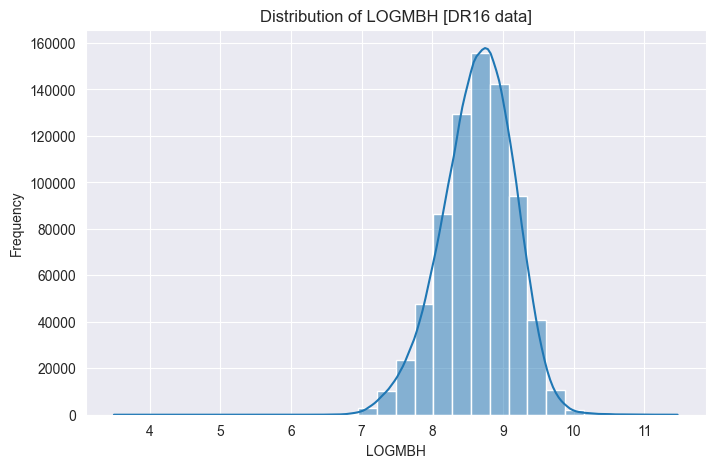

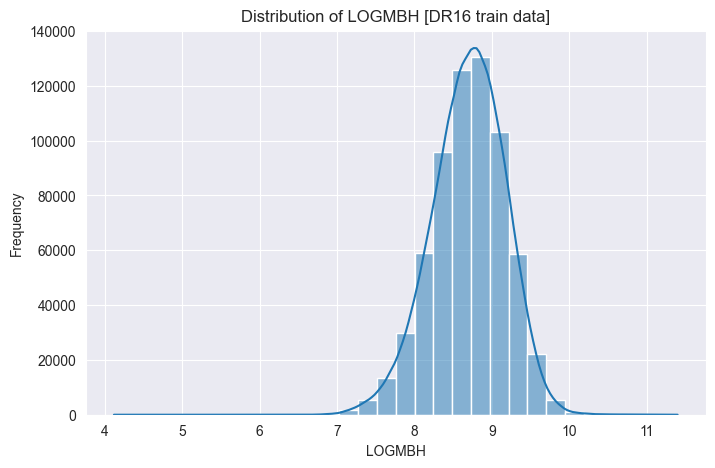

In [57]:
columns_to_plot = ["LOGMBH"]

for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_data_columns[column], kde=True, bins=30)
    plt.title(f"Distribution of {column} [DR16 data]")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()
    
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(DR16_train_data_columns[column], kde=True, bins=30)
    plt.title(f"Distribution of {column} [DR16 train data]")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

 ### Bivariate Relationships (العلاقات الثنائية)
see the conaction for any two column

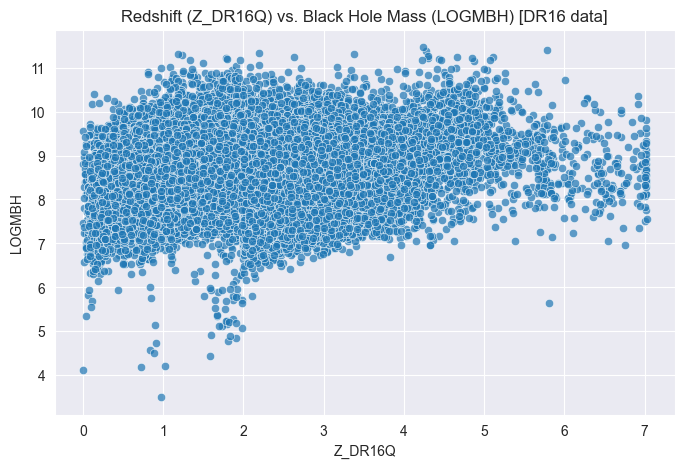

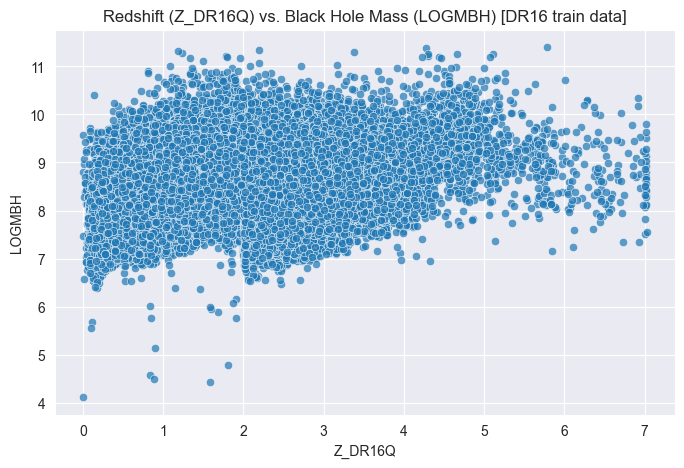

In [56]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGMBH", data=DR16_data_columns, alpha=0.7)
plt.title("Redshift (Z_DR16Q) vs. Black Hole Mass (LOGMBH) [DR16 data]")
plt.xlabel("Z_DR16Q")
plt.ylabel("LOGMBH")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGMBH", data=DR16_train_data_columns, alpha=0.7)
plt.title("Redshift (Z_DR16Q) vs. Black Hole Mass (LOGMBH) [DR16 train data]")
plt.xlabel("Z_DR16Q")
plt.ylabel("LOGMBH")
plt.show()

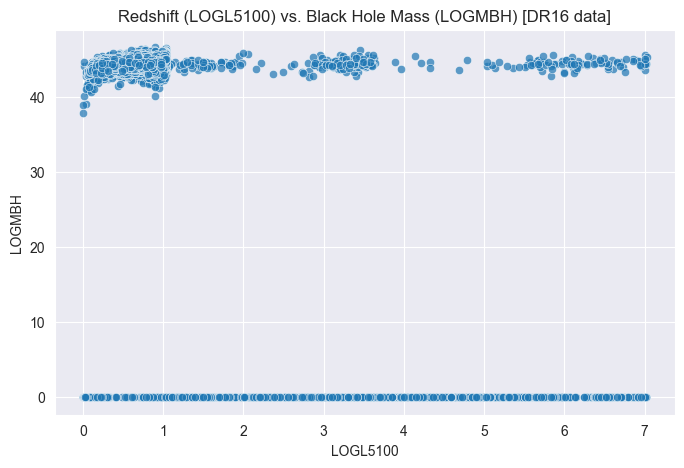

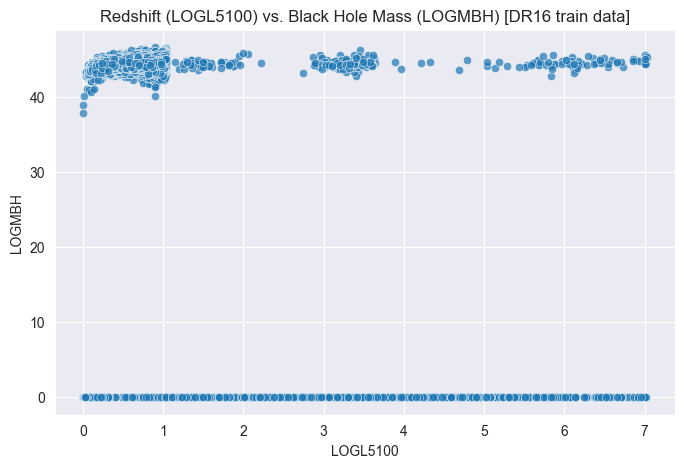

In [55]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGL5100", data=DR16_data_columns, alpha=0.7)
plt.title("Redshift (LOGL5100) vs. Black Hole Mass (LOGMBH) [DR16 data]")
plt.xlabel("LOGL5100")
plt.ylabel("LOGMBH")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x="Z_DR16Q", y="LOGL5100", data=DR16_train_data_columns, alpha=0.7)
plt.title("Redshift (LOGL5100) vs. Black Hole Mass (LOGMBH) [DR16 train data]")
plt.xlabel("LOGL5100")
plt.ylabel("LOGMBH")
plt.show()

 ### Correlation (الارتباط)
Explain the extent of the relationship between the columns

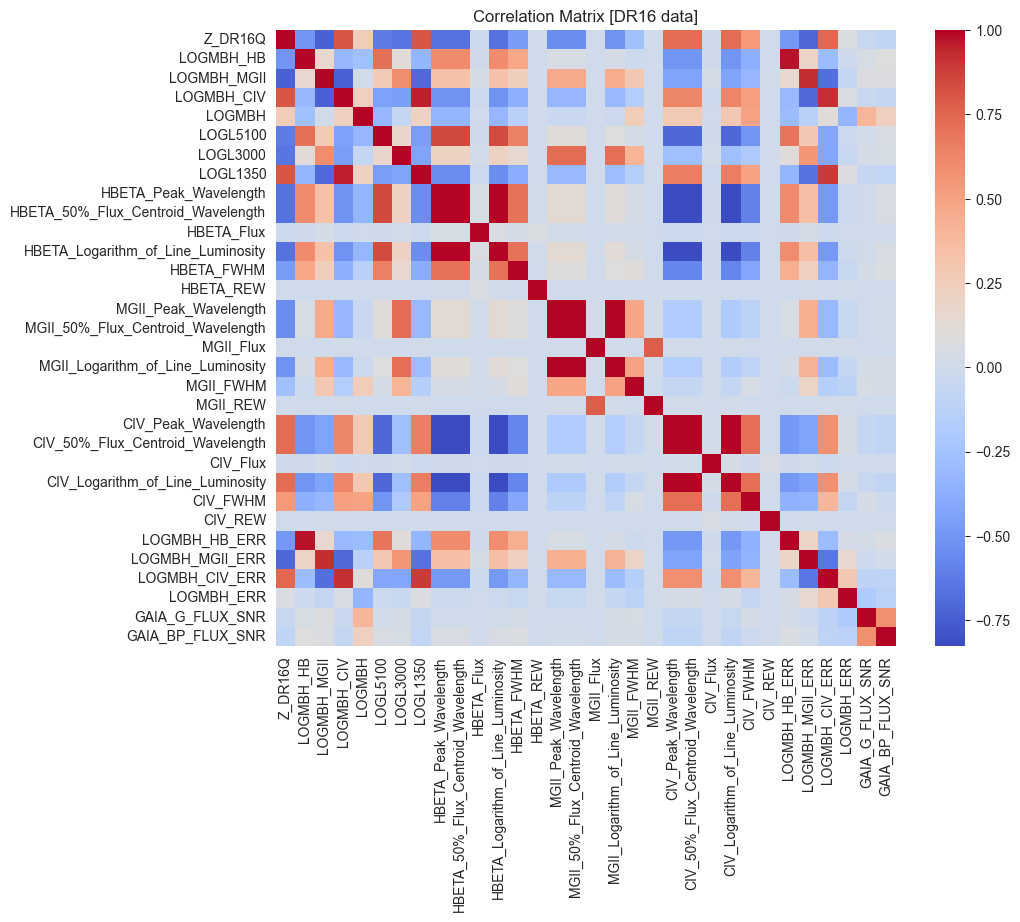

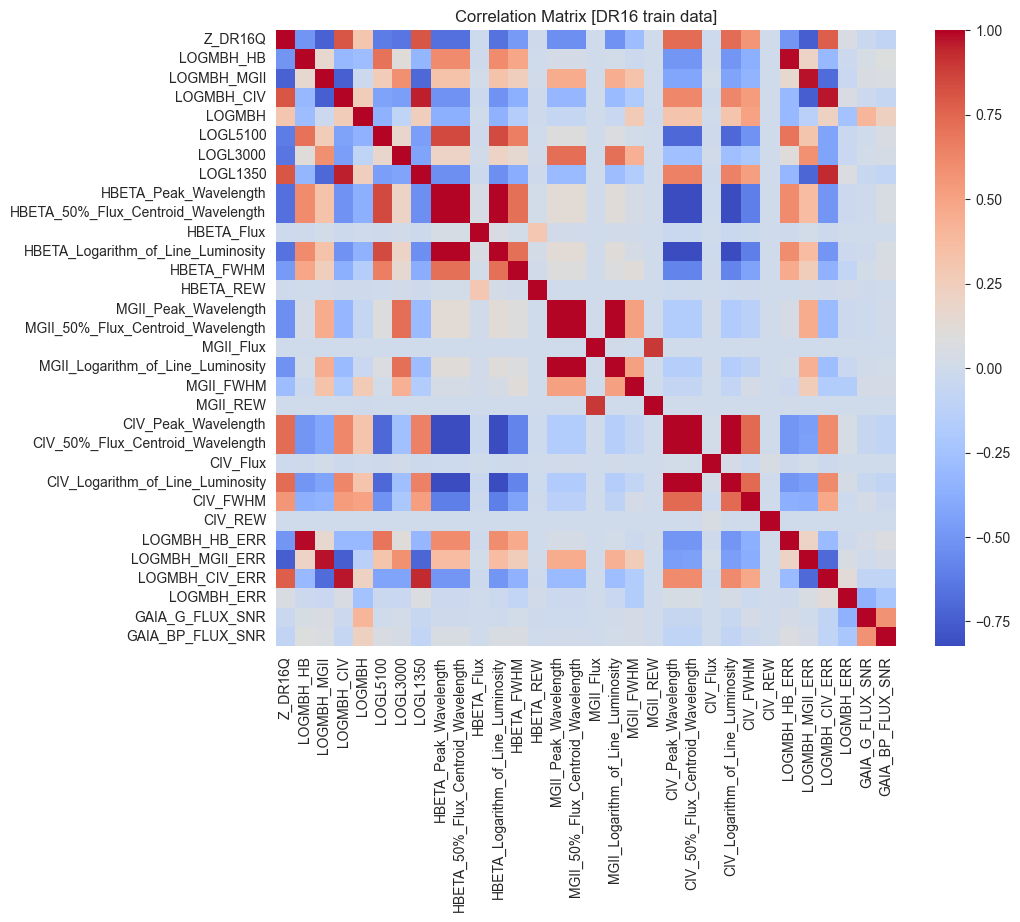

In [53]:
correlation_matrix = DR16_data_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix [DR16 data]")
plt.show()

correlation_matrix = DR16_train_data_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix [DR16 train data]")
plt.show()

### Multivariate Relationships (المقارنة بين الأعمدة)
Comparison of columns

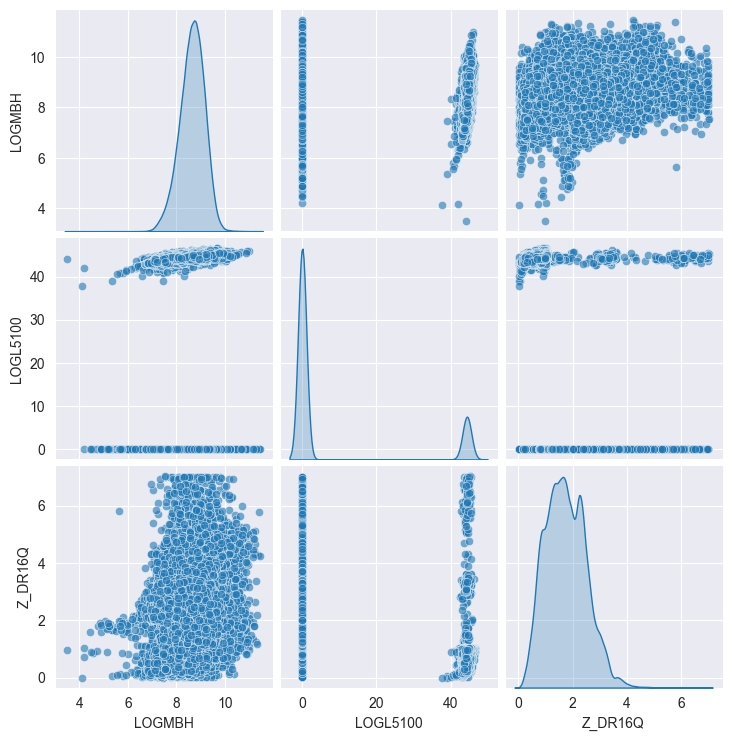

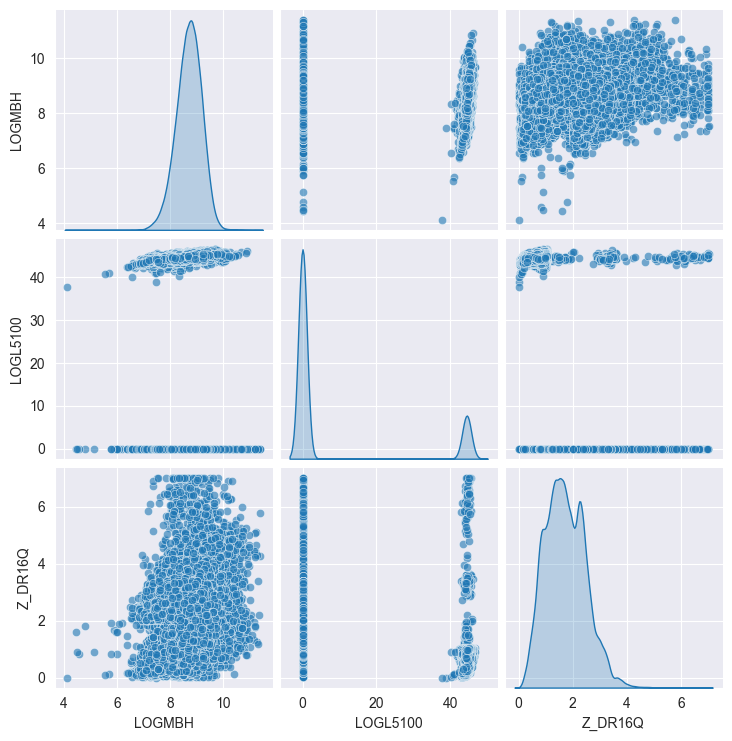

In [54]:
columns_to_pairplot = ["LOGMBH", "LOGL5100", "Z_DR16Q"]
sns.pairplot(DR16_data_columns[columns_to_pairplot], diag_kind="kde", plot_kws={"alpha": 0.6})
plt.show()

columns_to_pairplot = ["LOGMBH", "LOGL5100", "Z_DR16Q"]
sns.pairplot(DR16_train_data_columns[columns_to_pairplot], diag_kind="kde", plot_kws={"alpha": 0.6})
plt.show()

### 3D Charts

#### 3D plotting: `Z_DR16Q`, `LOGMBH`, `LOGL5100`

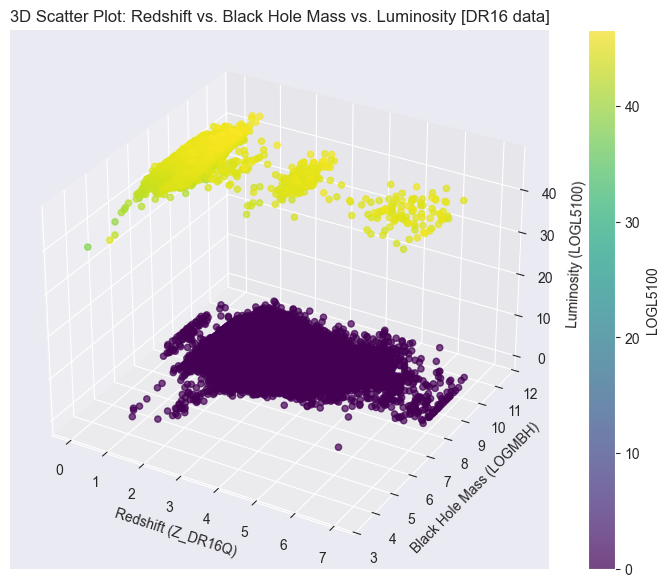

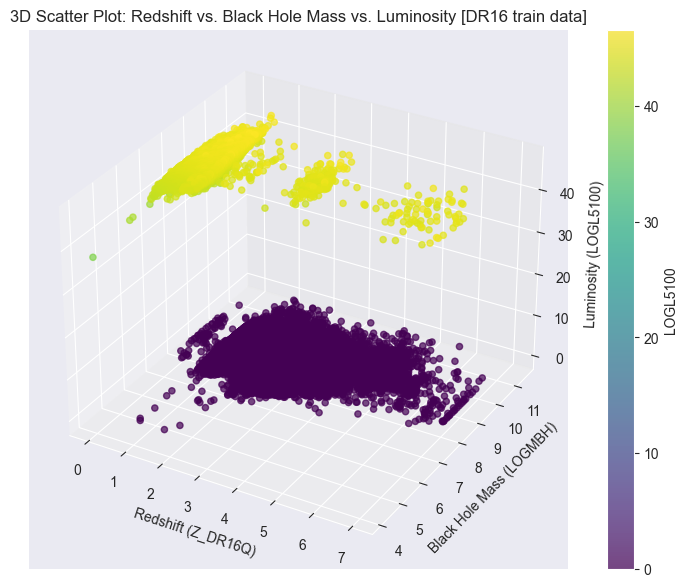

In [59]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_data_columns["Z_DR16Q"],
                DR16_data_columns["LOGMBH"],
                DR16_data_columns["LOGL5100"],
                c=DR16_data_columns["LOGL5100"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (LOGL5100)")

plt.colorbar(sc, label="LOGL5100")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Luminosity [DR16 data]")
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_train_data_columns["Z_DR16Q"],
                DR16_train_data_columns["LOGMBH"],
                DR16_train_data_columns["LOGL5100"],
                c=DR16_train_data_columns["LOGL5100"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (LOGL5100)")

plt.colorbar(sc, label="LOGL5100")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Luminosity [DR16 train data]")
plt.show()

#### 3D plotting: `Z_DR16Q`, `LOGMBH`, `GAIA_G_FLUX_SNR`

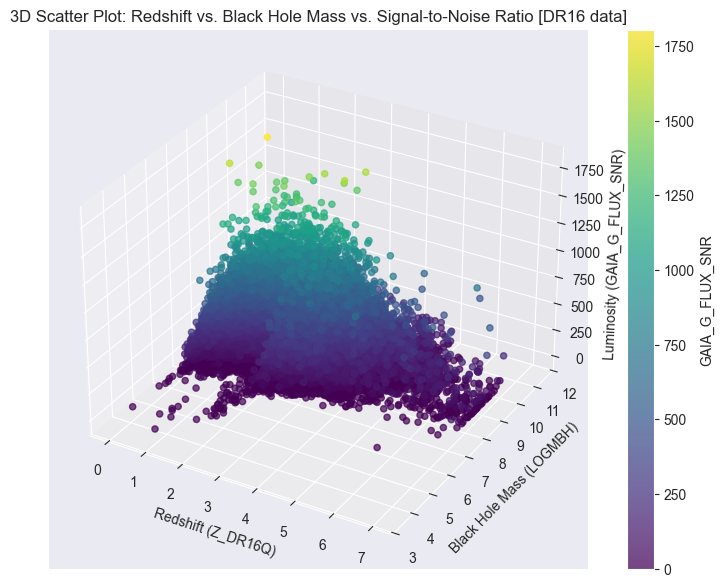

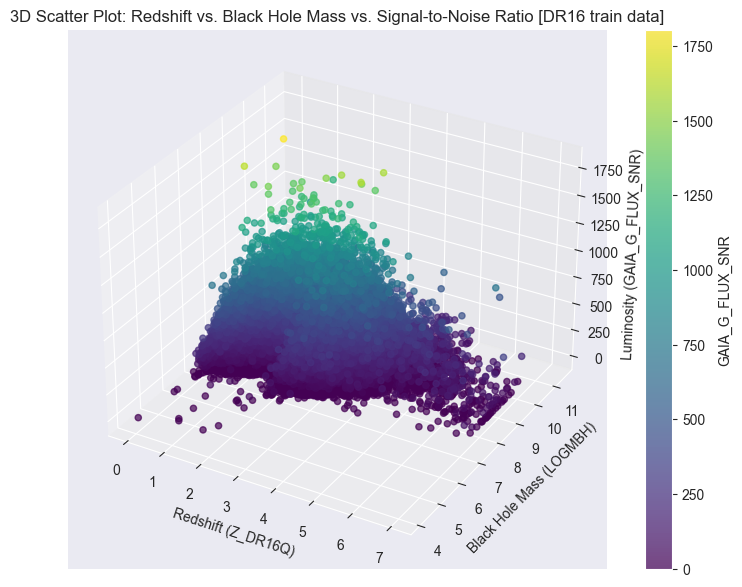

In [60]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_data_columns["Z_DR16Q"],
                DR16_data_columns["LOGMBH"],
                DR16_data_columns["GAIA_G_FLUX_SNR"],
                c=DR16_data_columns["GAIA_G_FLUX_SNR"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (GAIA_G_FLUX_SNR)")

plt.colorbar(sc, label="GAIA_G_FLUX_SNR")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Signal-to-Noise Ratio [DR16 data]")
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(DR16_train_data_columns["Z_DR16Q"],
                DR16_train_data_columns["LOGMBH"],
                DR16_train_data_columns["GAIA_G_FLUX_SNR"],
                c=DR16_train_data_columns["GAIA_G_FLUX_SNR"],
                cmap="viridis",
                alpha=0.7)

ax.set_xlabel("Redshift (Z_DR16Q)")
ax.set_ylabel("Black Hole Mass (LOGMBH)")
ax.set_zlabel("Luminosity (GAIA_G_FLUX_SNR)")

plt.colorbar(sc, label="GAIA_G_FLUX_SNR")
plt.title("3D Scatter Plot: Redshift vs. Black Hole Mass vs. Signal-to-Noise Ratio [DR16 train data]")
plt.show()

## Laws to Extract The Value of The Mass of a Black Hole

### *M_BH = f .(2 ^ ( FWHM_HB / 1000 )) . (0.5 ^ ( L_5100 / 10 ^ 44))*

In [35]:
FWHM_Hb = 4000
L_5100 = 2e44

log_M_BH = 6.91 + 2 * np.log10(FWHM_Hb / 1000) + 0.5 * np.log10(L_5100 / 1e44)
M_BH = 10**log_M_BH

print(f"Black Hole Mass: {M_BH:.2e} M_sun")

Black Hole Mass: 1.84e+08 M_sun


### *M_BH = A + B * log10( FWHM / 1000 ) + C * log10( L / 10 ^ 44)*

In [61]:
B = 2.0
ABH, CBH = 6.91, 0.5
AMGII, CMGII = 6.86, 0.5
ACIV, CCIV = 6.71, 0.53

input = 10

LOGMBH = DR16_train_data_columns["LOGMBH"].iloc[input]
LOGMBH_HB = DR16_train_data_columns["LOGMBH_HB"].iloc[input]
LOGMBH_MGII = DR16_train_data_columns["LOGMBH_MGII"].iloc[input]
LOGMBH_CIV = DR16_train_data_columns["LOGMBH_CIV"].iloc[input]

FWHM_HB = DR16_train_data_columns["HBETA_FWHM"].iloc[input]
FWHM_MGII = DR16_train_data_columns["MGII_FWHM"].iloc[input]
FWHM_CIV = DR16_train_data_columns["CIV_FWHM"].iloc[input]

L_5100 = DR16_train_data_columns["LOGL5100"].iloc[input]
L_3000 = DR16_train_data_columns["LOGL3000"].iloc[input]
L_1350 = DR16_train_data_columns["LOGL1350"].iloc[input]

def calculate_mass(A, B, C, FWHM, L):
    if FWHM > 0 and L > 0:
        log_mass = A + B * np.log10(FWHM / 1000) + C * np.log10(10 ** (L - 44))
        mass = 10**log_mass
        return log_mass, mass
    else:
        return None, None

log_M_BH, M_BH = calculate_mass(ABH, B, CBH, FWHM_HB, L_5100)

log_M_MGII, M_MGII = calculate_mass(AMGII, B, CMGII, FWHM_MGII, L_3000)

log_M_CIV, M_CIV = calculate_mass(ACIV, B, CCIV, FWHM_CIV, L_1350)

if log_M_BH :
    print(f"LOGMBH: {log_M_BH:.4f}")
    print(f"Mass of Black Hole (M_BH): {M_BH:.2e} M_sun")
print("LOGMBH_HB: ",LOGMBH_HB)
if log_M_MGII:
    print(f"LOGMMGII: {log_M_MGII:.4f}")
    print(f"Mass of Black Hole (M_MGII): {M_MGII:.2e} M_sun")
print("LOGMBH_MGII: ",LOGMBH_MGII)
if log_M_CIV:
    print(f"LOGMCIV: {log_M_CIV:.4f}")
    print(f"Mass of Black Hole (M_CIV): {M_CIV:.2e} M_sun")
print("LOGMBH_CIV: ",LOGMBH_CIV)
print("LOGMBH: ",LOGMBH)

LOGMBH_HB:  0.0
LOGMMGII: 8.7555
Mass of Black Hole (M_MGII): 5.70e+08 M_sun
LOGMBH_MGII:  8.809658282785275
LOGMBH_CIV:  0.0
LOGMBH:  8.809658282785275


## Training Data

### Split test, validation and train datasets

- Training: 70%
- Validation: 15%
- Test: 15%

In [62]:
X_train = DR16_train_data_columns.drop(columns=["LOGMBH"])
y_train = DR16_train_data_columns["LOGMBH"]

X_temp = DR16_data_columns.drop(columns=["LOGMBH"])
y_temp = DR16_data_columns["LOGMBH"]

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (652681, 31)
Validation set size: (373133, 31)
Test set size: (373134, 31)


In [63]:
print(np.isnan(X_train).sum())

print(np.isnan(y_train).sum())

Z_DR16Q                               0
LOGMBH_HB                             0
LOGMBH_MGII                           0
LOGMBH_CIV                            0
LOGL5100                              0
LOGL3000                              0
LOGL1350                              0
HBETA_Peak_Wavelength                 0
HBETA_50%_Flux_Centroid_Wavelength    0
HBETA_Flux                            0
HBETA_Logarithm_of_Line_Luminosity    0
HBETA_FWHM                            0
HBETA_REW                             0
MGII_Peak_Wavelength                  0
MGII_50%_Flux_Centroid_Wavelength     0
MGII_Flux                             0
MGII_Logarithm_of_Line_Luminosity     0
MGII_FWHM                             0
MGII_REW                              0
CIV_Peak_Wavelength                   0
CIV_50%_Flux_Centroid_Wavelength      0
CIV_Flux                              0
CIV_Logarithm_of_Line_Luminosity      0
CIV_FWHM                              0
CIV_REW                               0


In [64]:
X_train = np.where(np.isinf(X_train), np.nan, X_train)
X_test = np.where(np.isinf(X_test), np.nan, X_test)
X_val = np.where(np.isinf(X_val), np.nan, X_val)

X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
X_test = np.nan_to_num(X_test, nan=np.nanmean(X_test))
X_val = np.nan_to_num(X_val, nan=np.nanmean(X_val))

In [65]:
max_limit = 1e10

X_train = np.clip(X_train, -max_limit, max_limit)
X_temp = np.clip(X_temp, -max_limit, max_limit)
X_test = np.clip(X_test, -max_limit, max_limit)

In [66]:
print(np.isnan(X_train).sum())

print(np.isnan(y_train).sum())

0
0


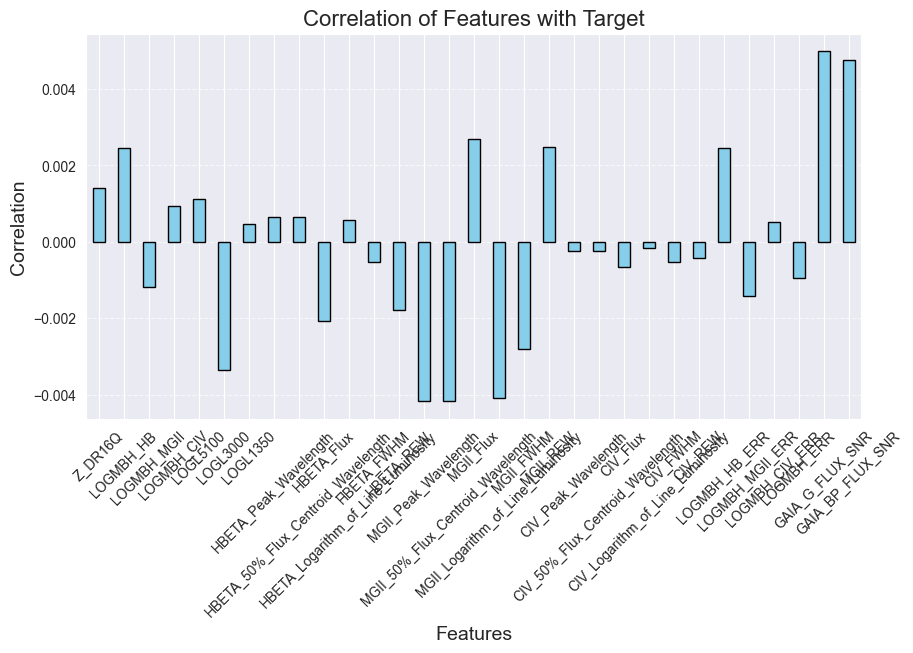

In [67]:
X_train_df = pd.DataFrame(X_train, columns=DR16_data_columns.drop(columns=["LOGMBH"]).columns)

y_train_series = pd.Series(y_train, name="Target")

correlation_matrix = X_train_df.corrwith(y_train_series)

plt.figure(figsize=(10, 5))
correlation_matrix.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Correlation of Features with Target", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Correlation", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Modeling
1. Linear Regression
2. Lasso Regression (L1 Regularization)
3. Ridge Regression (L2 Regularization)
4. Random Forest Regression

### Linear Regression

In [68]:
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

linear_regression_y_val_pred = linear_regression.predict(X_val)
linear_regression_y_test_pred = linear_regression.predict(X_test)

linear_regression_mse_val = mean_squared_error(y_val, linear_regression_y_val_pred)
linear_regression_mse_test = mean_squared_error(y_test, linear_regression_y_test_pred)

linear_regression_r2_val = r2_score(y_val, linear_regression_y_val_pred)
linear_regression_r2_test = r2_score(y_test, linear_regression_y_test_pred)


linear_regression_results = {"Model": "Linear Regression",
                             "Validation MSE": linear_regression_mse_val,
                             "Test MSE": linear_regression_mse_test,
                             "Validation R^2": linear_regression_r2_val,
                             "Test R^2": linear_regression_r2_test}

linear_regression_results_df = pd.DataFrame([linear_regression_results])

print(linear_regression_results_df)

               Model  Validation MSE      Test MSE  Validation R^2  \
0  Linear Regression    1.788427e+11  9.788360e+11   -6.889481e+11   

       Test R^2  
0 -3.766975e+12  


### Lasso Regression

In [69]:
lasso_regression = Lasso(alpha=0.4)

lasso_regression.fit(X_train, y_train)

lasso_regression_y_val_pred = lasso_regression.predict(X_val)
lasso_regression_y_test_pred = lasso_regression.predict(X_test)

lasso_regression_mse_val = mean_squared_error(y_val, lasso_regression_y_val_pred)
lasso_regression_mse_test = mean_squared_error(y_test, lasso_regression_y_test_pred)

lasso_regression_r2_val = r2_score(y_val, lasso_regression_y_val_pred)
lasso_regression_r2_test = r2_score(y_test, lasso_regression_y_test_pred)


lasso_regression_results = {"Model": "Lasso Regression",
                            "Validation MSE": lasso_regression_mse_val,
                            "Test MSE": lasso_regression_mse_test,
                            "Validation R^2": lasso_regression_r2_val,
                            "Test R^2": lasso_regression_r2_test}

lasso_regression_results_df = pd.DataFrame([lasso_regression_results])

print(lasso_regression_results_df)

              Model  Validation MSE  Test MSE  Validation R^2  Test R^2
0  Lasso Regression     1285.844225  0.134265    -4952.402415  0.483292


C:\Users\basil\PycharmProjects\black-hole-mass-predictor\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e+03, tolerance: 1.485e+01
  model = cd_fast.enet_coordinate_descent(


### Ridge Regression

In [70]:
ridge_regression = Ridge(alpha=0.3)

ridge_regression.fit(X_train, y_train)

ridge_regression_y_val_pred = ridge_regression.predict(X_val)
ridge_regression_y_test_pred = ridge_regression.predict(X_test)

ridge_regression_mse_val = mean_squared_error(y_val, ridge_regression_y_val_pred)
ridge_regression_mse_test = mean_squared_error(y_test, ridge_regression_y_test_pred)

ridge_regression_r2_val = r2_score(y_val, ridge_regression_y_val_pred)
ridge_regression_r2_test = r2_score(y_test, ridge_regression_y_test_pred)


ridge_regression_results = {"Model": "Ridge Regression",
                            "Validation MSE": ridge_regression_mse_val,
                            "Test MSE": ridge_regression_mse_test,
                            "Validation R^2": ridge_regression_r2_val,
                            "Test R^2": ridge_regression_r2_test}

ridge_regression_results_df = pd.DataFrame([ridge_regression_results])

print(ridge_regression_results_df)

              Model  Validation MSE      Test MSE  Validation R^2  \
0  Ridge Regression    1.126300e+13  6.164429e+13   -4.338798e+13   

       Test R^2  
0 -2.372333e+14  


C:\Users\basil\PycharmProjects\black-hole-mass-predictor\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.01595e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### Random Forest Regression

In [71]:
random_forest_regression = RandomForestRegressor(random_state=42, n_estimators=30, max_leaf_nodes=5, max_depth=5)

random_forest_regression.fit(X_train, y_train)

random_forest_regression_y_val_pred = random_forest_regression.predict(X_val)
random_forest_regression_y_test_pred = random_forest_regression.predict(X_test)

random_forest_regression_mse_val = mean_squared_error(y_val, random_forest_regression_y_val_pred)
random_forest_regression_mse_test = mean_squared_error(y_test, random_forest_regression_y_test_pred)

random_forest_regression_r2_val = r2_score(y_val, random_forest_regression_y_val_pred)
random_forest_regression_r2_test = r2_score(y_test, random_forest_regression_y_test_pred)


random_forest_regression_results = {"Model": "Random Forest Regression",
                                    "Validation MSE": random_forest_regression_mse_val,
                                    "Test MSE": random_forest_regression_mse_test,
                                    "Validation R^2": random_forest_regression_r2_val,
                                    "Test R^2": random_forest_regression_r2_test}

random_forest_regression_results_df = pd.DataFrame([random_forest_regression_results])

print(random_forest_regression_results_df)

                      Model  Validation MSE  Test MSE  Validation R^2  \
0  Random Forest Regression        0.067589  0.067672        0.739631   

   Test R^2  
0   0.73957  


### Make Predictions

In [72]:
y_new_pred = random_forest_regression.predict([X_test[0]])

print("Predicted Value:", y_new_pred[0])
print("Actual Value:", y_test.iloc[0])

Predicted Value: 9.175342448738895
Actual Value: 9.099238005991284


### Save the Results (Performance Metrics)

In [73]:
results = pd.concat([linear_regression_results_df,
                      lasso_regression_results_df,
                      ridge_regression_results_df,
                      random_forest_regression_results_df],
                     ignore_index=True)

results.to_csv("results.csv", index=False)

results

,Model,Validation MSE,Test MSE,Validation R^2,Test R^2
0,Linear Regression,1.788427e+11,9.788360e+11,-6.889481e+11,-3.766975e+12
1,Lasso Regression,1.285844e+03,1.342650e-01,-4.952402e+03,4.832916e-01
2,Ridge Regression,1.126300e+13,6.164429e+13,-4.338798e+13,-2.372333e+14
3,Random Forest Regression,6.758876e-02,6.767186e-02,7.396307e-01,7.395701e-01


### Save the Models

In [74]:
joblib.dump(linear_regression, "models/linear_regression.pkl")
joblib.dump(lasso_regression, "models/lasso_regression.pkl")
joblib.dump(ridge_regression, "models/ridge_regression.pkl")
joblib.dump(random_forest_regression, "models/random_forest_regression.pkl")

['models/random_forest_regression.pkl']